## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
# the number of rows and columns of the dataset
df.shape

(294478, 5)

In [5]:
# the value of column landing_page
df['landing_page'].value_counts()

old_page    147239
new_page    147239
Name: landing_page, dtype: int64

In [6]:
# the value of column group
df['group'].value_counts()

treatment    147276
control      147202
Name: group, dtype: int64

There are 294478 rows in the dataset.

c. The number of unique users in the dataset.

In [7]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [8]:
# The general proportion of users converted.
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [9]:
# The number of treatment
(df['group'] == "treatment").value_counts()

True     147276
False    147202
Name: group, dtype: int64

In [10]:
# The number of new_page
(df['landing_page'] == "new_page").value_counts()

True     147239
False    147239
Name: landing_page, dtype: int64

When the new_page and treatment don't match, it includes two kinds of scenario:
1. not new_page(old_page) and  treatment
2. new_page and  not treatment(control)

we add the values of the two kinds of scenario

In [11]:
# the number when not new_page(old_page) match treatment
df[(df['group'] == "treatment")&(df['landing_page'] != "new_page")].shape[0]

1965

In [12]:
# the number when new_page match not treatment(control)
df[(df['group'] != "treatment")&(df['landing_page'] == "new_page")].shape[0]

1928

In [13]:
# adding the values of the two kinds of scenario
counts = 1965 + 1928
counts

3893

There are 3893 times the new_page and treatment don't match.

f. Do any of the rows have missing values?

In [14]:
df.describe()

,user_id,converted
count,294478.000000,294478.000000
mean,787974.124733,0.119659
std,91210.823776,0.324563
min,630000.000000,0.000000
25%,709032.250000,0.000000
50%,787933.500000,0.000000
75%,866911.750000,0.000000
max,945999.000000,1.000000


In [15]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

Obviously, there is no missing values for every column.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [16]:
# Dropping of the rows where treatment does not match with new_page or control does not match with old_pag
# This means df2 only includes rows where strict matches exist. 
df2 = df[((df['group'] == "treatment")&(df['landing_page'] == "new_page")) | ((df['group'] == "control")&(df['landing_page'] == "old_page"))]

In [17]:
# the size of the new dataset df2
df2.shape

(290585, 5)

In [18]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [19]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [20]:
df2['user_id'].nunique()

290584

In [21]:
# The number of rows in the dataset 
df2.shape[0]

290585

In [29]:
# 290585 - 290584 = 1, obviously, there is one duplicated value.

In [22]:
# another way to see how many duplicated value in this column
sum(df2['user_id'].duplicated())

1

b. There is one **user_id** repeated in **df2**.  What is it?

In [23]:
# when df2.user_id.duplicated() = True, it is the position of repeated user_id. 
df2.user_id[df2.user_id.duplicated()]


2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [24]:
#row number is 2893
df2.loc[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [25]:
# Drop the specific row with index number 2893
df2 = df2.drop([2893])
 

In [26]:
# check the number of rows after dropping the row, it should be 290585-1=290584
df2.shape[0]

290584

In [27]:
# Check agin to make sure the duplicated value is removed

df2.loc[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [28]:
# The general conversion percentage
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [29]:
df2.groupby('group')['converted'].mean()

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [30]:
# We can get the answer from the above. 
# The difference between the two is not obvious.

d. What is the probability that an individual received the new page?

In [31]:
# numbers of values in the column landing_page
df2['landing_page'].value_counts()

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

In [32]:
# the probability that an individual received the new page
percentage = 145310/(145310+145274)
percentage

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

The above descriptive statistics indicate:

a shows the general probability of an individual converting regardless of the page they receive is 11.96%.

b shows that if an individual was in the control group, the probability they converted is 12.04%.

c shows that if an individual was in the treatment group, the probability they converted is 11.88%.

From these descriptive statistics, I think there is not sufficient evidence to conclude that the new treatment page leads to more conversion because these three digital are so close.



<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

Null hypothesis: Pold >= Pnew  

Alternative hypothesis: Pnew > Pold  

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [33]:
# the conversion rate for  𝑝𝑛𝑒𝑤  under the null
Pnew = len(df2.query('group == "treatment" and converted == 1'))/len(df2.query('group=="treatment"'))
Pnew

0.11880806551510564

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [34]:
# the conversion rate for  𝑝𝑜𝑙𝑑  under the null
Pold = len(df2.query('group=="control" and converted==1'))/len(df2.query('group=="control"'))
Pold

0.1203863045004612

c. What is $n_{new}$, the number of individuals in the treatment group?

In [35]:
# the number of individuals in the treatment group
n_new = len(df2.query('group == "treatment" '))
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [36]:
# the number of individuals in the control group
n_old = len(df2.query('group == "control" '))
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [37]:
# Simulate  𝑛_𝑛𝑒𝑤  transactions
new_page_converted = np.random.choice([0, 1], n_new, p = [Pnew, 1-Pnew])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [38]:
# Simulate  𝑛_𝑜𝑙𝑑  transactions
old_page_converted = np.random.choice([0, 1], n_old, p =[Pold, 1-Pold])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [40]:
# 𝑝𝑛𝑒𝑤  -  𝑝𝑜𝑙𝑑  for simulated values
obs_diff= new_page_converted.mean() - old_page_converted.mean()
obs_diff

0.0018260312281810354

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [53]:
# create sampling distribution of difference in average conversion rate
# with boostrapping
p_diffs = []
size = df2.shape[0]
for _ in range(1000):
    # this is not right: b_samp = df2.sample(size, replace = True)
    new_page_converted = np.random.choice([0, 1], size = n_new, p = [Pnew, 1-Pnew]).mean()
    old_page_converted = np.random.choice([0, 1], size = n_old, p = [Pold, 1-Pold]).mean()
    p_diffs.append(new_page_converted - old_page_converted)
   

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [54]:
# convert to numpy array
p_diffs = np.array(p_diffs)

In [56]:
# create a random normal distribution centered at 0 with the same spread and size.

null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

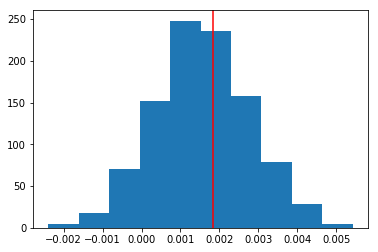

In [57]:
# plot sampling distribution
plt.hist(p_diffs);

# plot line for observed statistic
plt.axvline(obs_diff, c='red')

From the above histogram, we can see the red line is not far away the mean value of the normal distribution. It seems they come from the same distribution. 

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [58]:
# compute p value
(null_vals > obs_diff).mean()

0.065000000000000002

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

This is called p-value. For accepting null hypothesis p-value should be greater than suggested p-value. If the Type-1 error rate is 0.05. P > 0.05 means the diffrence is not statisticlly significant. 

So we have no reason to reject null- hypothesis. New-page is not doing significantly better than the old page. 


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [59]:
convert_old = len(df2.query('converted==1 and landing_page=="old_page"'))
convert_new = len(df2.query('converted==1 and landing_page=="new_page"'))
n_old = len(df2.query('landing_page=="old_page"'))
n_new = len(df2.query('landing_page=="new_page"'))
n_new


145310

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [60]:
z_score, p_value = sm.stats.proportions_ztest([convert_old,convert_new], [n_old, n_new],alternative='smaller') 

print(z_score,p_value)

1.31092419842 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

In [61]:
from scipy.stats import norm
norm.cdf(z_score) 

0.90505831275902449

In [62]:
# the critical value of 95% confidence
norm.ppf(1-(0.05)) 

1.6448536269514722

P-value (0.905)< 95% and z_score (1.31) is less than critical value of 95% confidence(1.64). This means we have fail to reject null hypothesis. So the null hypothesis is accepted. The new pages are not better than the old pages. This conclusion is the same as the  findings in parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

The result is 0 or 1 (no conversion or a conversion). This is not a continous numeric response. consequently, a logistic regression should be performed in this case.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [63]:
# Add an intercept column, as well as an ab_page column
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In [64]:
# to check the values of the column treatment and column ab_page, make sure they match
df2['group'].value_counts()

treatment    145310
control      145274
Name: group, dtype: int64

In [65]:
# these values match
df2['ab_page'].value_counts()

1    145310
0    145274
Name: ab_page, dtype: int64

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [66]:
# creat the logistic regression model
logit_mod = sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results = logit_mod.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-27 17:12 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

p-value associated with ab_page is 0.1899.

This value is larger than 0.05. So the ab_page has no significant impact on the conversion rate.

In Logistic regression:

H0: Pnew - Pold = 0    

H1: Pnew - Pold != 0

Part 2:

H0: Pnew - Pold = 0    

H1: Pnew - Pold > 0

The alternative hypotheses are different. Logistic regression hypothesis has two sided test and Part 2 has one sided test.


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

The advantage is we can increase the explantory power of logistic regression by adding other factors. The disadvantage is that additional factors may have multicollinearity with existing factors. And it may incurs more cost and time to collect the data of other factors.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [67]:
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [68]:
# to see what are the values in the column of country. 
countries['country'].value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [70]:
# to merge together the two datasets
new = countries.set_index('user_id').join(df2.set_index('user_id'), how = 'inner')
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [72]:
# there are three dummy varibles, so we need two new columns.
new[['US', 'UK']] = pd.get_dummies(new['country'])[['US', "UK"]]
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1


In [73]:
# create the second logistic regressioin model
logit_mod2 = sm.Logit(new['converted'], new[['intercept','ab_page', 'US', 'UK']])
results2 = logit_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-27 17:15 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

The P values of varibles US and UK are all larger than 0.05. So these two varibles have no significant impact on the conversion.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [74]:
# create the new column
new['US_ab_page'] = new['US']*new['ab_page']
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,US_ab_page
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [75]:
# create another new column
new['UK_ab_page'] = new['UK']*new['ab_page']
new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,UK,US_ab_page,UK_ab_page
user_id,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1


In [76]:
# create the third logistic regression model
logit_mod3 = sm.Logit(new['converted'], new[['intercept','ab_page', 'US', 'UK', 'US_ab_page', 'UK_ab_page']])
results3 = logit_mod3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-05-27 17:15 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
==================================================================

"""

Conclusions based on statistical reasoning:

Both the added two new varibles (US_ab_page and UK_ab_page) have P values which are larger than 0.05. We can say these two varibles have no significant impact on the conversion. And there is not sinificant relation between country and page received.And the P value of ab_page is 0.1947 which means the varible is not statistically significant to explain the conversion.Similarly, the varibles of US and UK are not making  statistically difference in the regression.

Based on the descriptive statistics and inferential statistics, we think that the new page did not do better than the old page when considerring the conversion.

Practical reasoning for the situation:

1. Time. It is better for the e-commerce website to run the experiment longer to make their decision even though the statistics did not approve the new page right now. For old customers, it is not easy for them to accept new pages quickly.They need more time to adjust to the new webpages than new customers do. The existing customers would bias the results in the short time frame. During the transition time, the company might put more resource to introduce the new page to old customers. Then the company could review the decision later.


2. Customers. In this test, the difference between the control group and the treatment group is whether customers use new pages or not. This design ignores the difference between old customers and new customers. If the company could introduce the new pages and old pages to new customers based on the purchasing history and Web browser cache. Then it is easier to decide which version of web page is better.



.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!> 


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [77]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0